In [1]:
from collections import namedtuple
from networkx import read_edgelist, set_node_attributes
from pandas import read_csv, Series
from numpy import array
import pickle
import pandas as pd
import networkx as nx
from mxnet import ndarray as nd

In [40]:
aa = LoadData()

d:\python36\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [41]:
bb=aa.get_pathway_net()

In [59]:
import matplotlib.pyplot as plt
pathway_net_nx = nx.from_numpy_array(bb['A'].asnumpy())

d:\python36\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


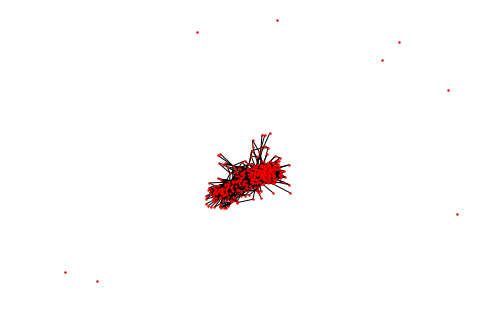

In [60]:
fig = plt.figure()
nx.draw(pathway_net_nx, with_labels=False,node_size=2)
plt.show()

In [39]:
class LoadData():
    def __init__(self):
        hsa2symbol = pd.read_csv('data/hsa2symbol.csv', sep=',', header=None)
        hsa2symbol = hsa2symbol.set_index(hsa2symbol[1])
        genelist = pd.read_csv('data/symbol_nodes.csv', sep='\t', header=None)
        # genelist_order
        self.genelist_order = sorted(list(genelist[0]))
        
        with open('data/pathway2enzyme.pickle.txt', 'rb') as file:
            self.enzymeDict_load = pickle.load(file)
        res = [i for path in self.enzymeDict_load.keys() for i in self.enzymeDict_load[path]['entry2gene']]
        res = pd.DataFrame(res)
        # transform hsaID to gene symbol
        for i in range(res.shape[0]):
            gl = [hsa2symbol.at[h, 0] for h in res.iat[i, 1].split(' ') if h in hsa2symbol.index]
            res.iat[i, 1] = ' '.join(gl)
        # path_entry_gene
        # 一些hsa没有对应symboy，这导致一些entry没有对应gene，删除这样的entryID
        self.res = res.loc[-(res[1] == '')]
        entrygene = self.res.loc[-self.res[1].duplicated(), 1]
        entrygene = entrygene.reset_index(drop=True).reset_index()
        geneset2entryID = dict(zip(entrygene[1], entrygene['index']))
        self.res['entryID'] = self.res[1].map(geneset2entryID).apply(lambda x: 'entry' + str(x))
        # entrylist 排序
        self.entrylist = sorted(list(set(self.res['entryID'])), key=lambda x: int(x[5:]))
        # pathwaylist
        pathway_nodes = pd.read_csv('data/pathway_nodes.csv', header=None)
        self.pathwaylist = sorted(list(pathway_nodes[0]))
        
    def get_ppi_net(self):
        # 加载PPI
        ppi_net = pd.read_csv('data/protein_protein_edges.csv', sep=',', names=['p1', 'p2', 's'], header=None)
        ppi_net_nx = nx.from_pandas_edgelist(ppi_net, 'p1', 'p2')
        # 按照genelist排序
        ppi_A = nd.array(nx.to_numpy_matrix(ppi_net_nx, nodelist=self.genelist_order))
        return {'edges': ppi_net, 'A': ppi_A}
    
    def protein_entry_features(self):
        # gene_to_index
        gene_to_index = dict(zip(self.genelist_order, list(range(len(self.genelist_order)))))
        # entry_to_gene
        entry_to_gene = dict(zip(self.res['entryID'], self.res[1]))
        
        FeaturesTransformSet = namedtuple(
            'FeaturesTransformSet',
            field_names=['gene_to_index', 'entrylist', 'entry_to_gene'])
        return FeaturesTransformSet(gene_to_index, self.entrylist, entry_to_gene)
    
    def get_entry_net(self):
        # 创建 pathid_entryid: entryid 字典
        tmpdict = dict(zip(self.res[0], self.res['entryID']))
        entry_to_entry = pd.DataFrame(columns=['id1', 'id2'])
        for k in self.enzymeDict_load.keys():
            entry_tmp = pd.DataFrame(columns=['id1', 'id2'])
            entry_tmp['id1'] = self.enzymeDict_load[k]['entry_entry_edges']['id1'].map(tmpdict)
            entry_tmp['id2'] = self.enzymeDict_load[k]['entry_entry_edges']['id2'].map(tmpdict)
            # 删除 na 值
            entry_tmp = entry_tmp.dropna().reset_index(drop=True)
            entry_to_entry = pd.concat([entry_to_entry, entry_tmp])
        # 删除重复
        entry_to_entry_drop = entry_to_entry.drop_duplicates()
        entry_to_entry_drop = entry_to_entry_drop.loc[-(entry_to_entry_drop['id1'] == entry_to_entry_drop['id2'])]
        # 删除重复的边 (A-B) (B-A) 会被删除
        a = entry_to_entry_drop.apply(lambda x: str(sorted(x.tolist())), axis=1)
        pos = pd.DataFrame(a).duplicated()
        entry_to_entry_drop = entry_to_entry_drop.loc[-pos].reset_index(drop=True)
        # 利用networkx生成网络， 提取网络矩阵
        entry_net_nx = nx.from_pandas_edgelist(entry_to_entry_drop, 'id1', 'id2')
        entry_A = nd.array(nx.to_numpy_matrix(entry_net_nx, nodelist=self.entrylist))

        return {'edges': entry_to_entry_drop, 'A': entry_A}
    
    def entry_pathway_features(self):
        # pathway_to_entry
        self.res['pathwayID'] = self.res[0].apply(lambda x: x.split('_')[0])
        pathway_to_entry = dict(self.res.groupby('pathwayID')['entryID'].apply(lambda x: ' '.join(x)))

        # entry_to_index
        entry_to_index = dict(zip(self.entrylist, list(range(len(self.entrylist)))))

        FeaturesTransformSet = namedtuple(
            'FeaturesTransformSet',
            field_names=['pathwaylist', 'entry_to_index', 'pathway_to_entry'])

        return FeaturesTransformSet(self.pathwaylist, entry_to_index, pathway_to_entry)
    
    def get_pathway_net(self):
        pathway_net = pd.read_csv('data/pathway2pathway.csv', sep=',', names=['p1', 'p2'])
        pathway_net_nx = nx.from_pandas_edgelist(pathway_net, 'p1', 'p2')
        pathway_A = nd.array(nx.to_numpy_matrix(pathway_net_nx, nodelist=self.pathwaylist))
        return {'edges': pathway_net, 'A': pathway_A}